# Conditional Bernoulli Project

## I-Rejection Sampling

### Rejection sampler definition and acceptance for different sizes/k

In [24]:
import numpy as np
from joblib import Parallel, delayed

def rejection_sampler(p, k, n_samples=1000):
    
    """
    Generate samples from Bernoulli distributions conditioned on their sum being k.

    Parameters:
    - p: Probabilities for each Bernoulli variable.
    - k: Desired sum.
    - n_samples: Number of samples to generate.

    Returns:
    - accepted_samples: Array of valid samples.
    - attempts: Total number of attempts.
    """
    p = np.array(p)
    N = len(p)
    accepted_samples = []
    attempts = 0

    while len(accepted_samples) < n_samples:
        # Generate a sample of N independent Bernoulli random variables
        sample = np.random.rand(N) < p
        attempts += 1
        # Check if the sum equals k
        if sample.sum() == k:
            accepted_samples.append(sample)
    
    return np.array(accepted_samples), attempts



# Dictionary to store acceptance rates for each size and k
acceptance_rates = {}

# Implement the algorithm for different p arrays of varying sizes
for size in [10, 50, 100, 500, 1000]:  # Array sizes to test
    p = np.random.rand(size)
    acceptance_rates[size] = {}
    print(f"Testing for array size: {size}")
    # Test for different values of k ranging from The 
    exp = np.sum(p)  # Calculate the expected sum of the Bernoulli variables
    
    k_min = int(max(1, exp - len(p) / 20))  # Lower bound for k
    k_max = int(min(exp + len(p) / 20, size))  # Upper bound for k
    for k in range(k_min, k_max + 1):  # k ranging from 1 to 100 or size, whichever is smaller
        # Use a single sample for large arrays to avoid memory issues
        n_samples = 10 if size >= 500 else 100
        samples, attempts = rejection_sampler(p, k, n_samples=n_samples)
        acceptance_rate = samples.shape[0] / attempts
        acceptance_rates[size][k] = acceptance_rate
        print(f"Array size: {size}, k: {k}")
        print("Number of accepted samples:", samples.shape[0])
        print("Total attempts made:", attempts)
        print("Acceptance rate:", acceptance_rate)
        print("-" * 40)




Testing for array size: 10
Array size: 10, k: 4
Number of accepted samples: 100
Total attempts made: 369
Acceptance rate: 0.27100271002710025
----------------------------------------
Array size: 10, k: 5
Number of accepted samples: 100
Total attempts made: 376
Acceptance rate: 0.26595744680851063
----------------------------------------
Testing for array size: 50
Array size: 50, k: 22
Number of accepted samples: 100
Total attempts made: 1260
Acceptance rate: 0.07936507936507936
----------------------------------------
Array size: 50, k: 23
Number of accepted samples: 100
Total attempts made: 1048
Acceptance rate: 0.09541984732824428
----------------------------------------
Array size: 50, k: 24
Number of accepted samples: 100
Total attempts made: 722
Acceptance rate: 0.13850415512465375
----------------------------------------
Array size: 50, k: 25
Number of accepted samples: 100
Total attempts made: 670
Acceptance rate: 0.14925373134328357
----------------------------------------
Arra

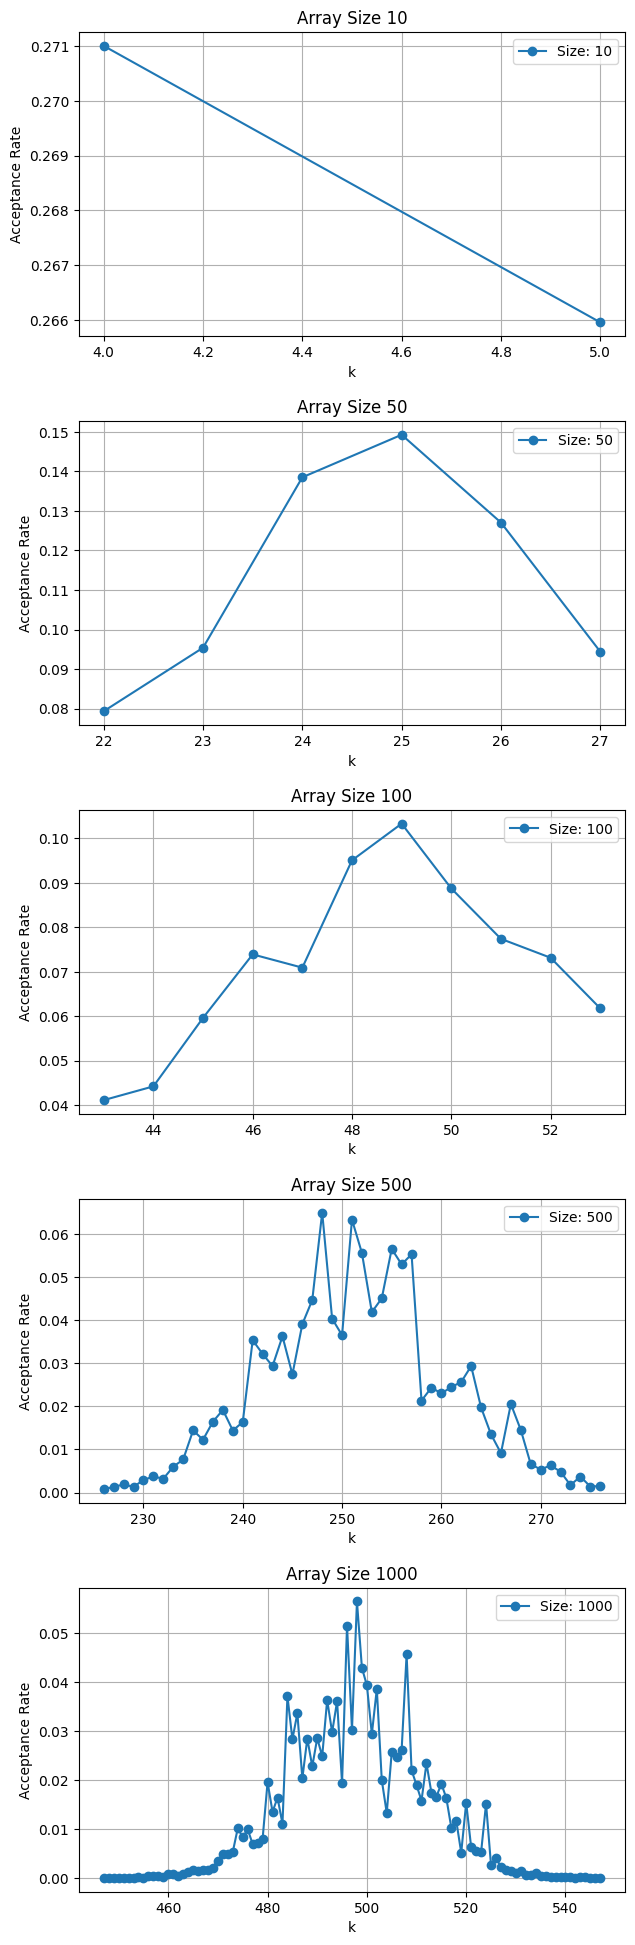

In [30]:
import matplotlib.pyplot as plt

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=len(acceptance_rates), ncols=1, figsize=(7, 20))
fig.tight_layout(pad=4.0)

# Iterate over the sizes and their corresponding k_dict
for ax, (size, k_dict) in zip(axes, acceptance_rates.items()):
    k_values = list(k_dict.keys())
    rates = list(k_dict.values())
    
    ax.plot(k_values, rates, marker='o', label=f'Size: {size}')
    ax.set_xlabel('k')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title(f'Array Size {size}')
    ax.legend()
    ax.grid(True)

plt.show()



### Acceptance rate for varying entropies

In [134]:
from scipy.stats import entropy
from tqdm import tqdm


acceptance_rates_entropy = {}

for size in [10,100,1000,10000]:
    print(f"Size: {size}")
    random_arrays = [np.random.rand(size) for _ in range(5000)]
    entropies = [entropy(arr, base=2) for arr in random_arrays]

    # Sort arrays by entropy and extract
    sorted_indices = np.argsort(entropies)[::(len(entropies)) // 50]  
    sorted_arrays = [random_arrays[i] for i in sorted_indices]

    # Calculate acceptance rates for each array
    acceptance_rates_entropy[size] = {}
    for arr in tqdm(sorted_arrays):
        samples, attempts = rejection_sampler(arr, int(np.sum(arr)), n_samples=100)
        acceptance_rate = samples.shape[0] / attempts
        acceptance_rates_entropy[size][entropy(arr,base=2)] = acceptance_rate



Size: 10


100%|██████████| 50/50 [00:00<00:00, 874.32it/s]


Size: 100


100%|██████████| 50/50 [00:00<00:00, 355.33it/s]


Size: 1000


100%|██████████| 50/50 [00:01<00:00, 46.65it/s]


Size: 10000


100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


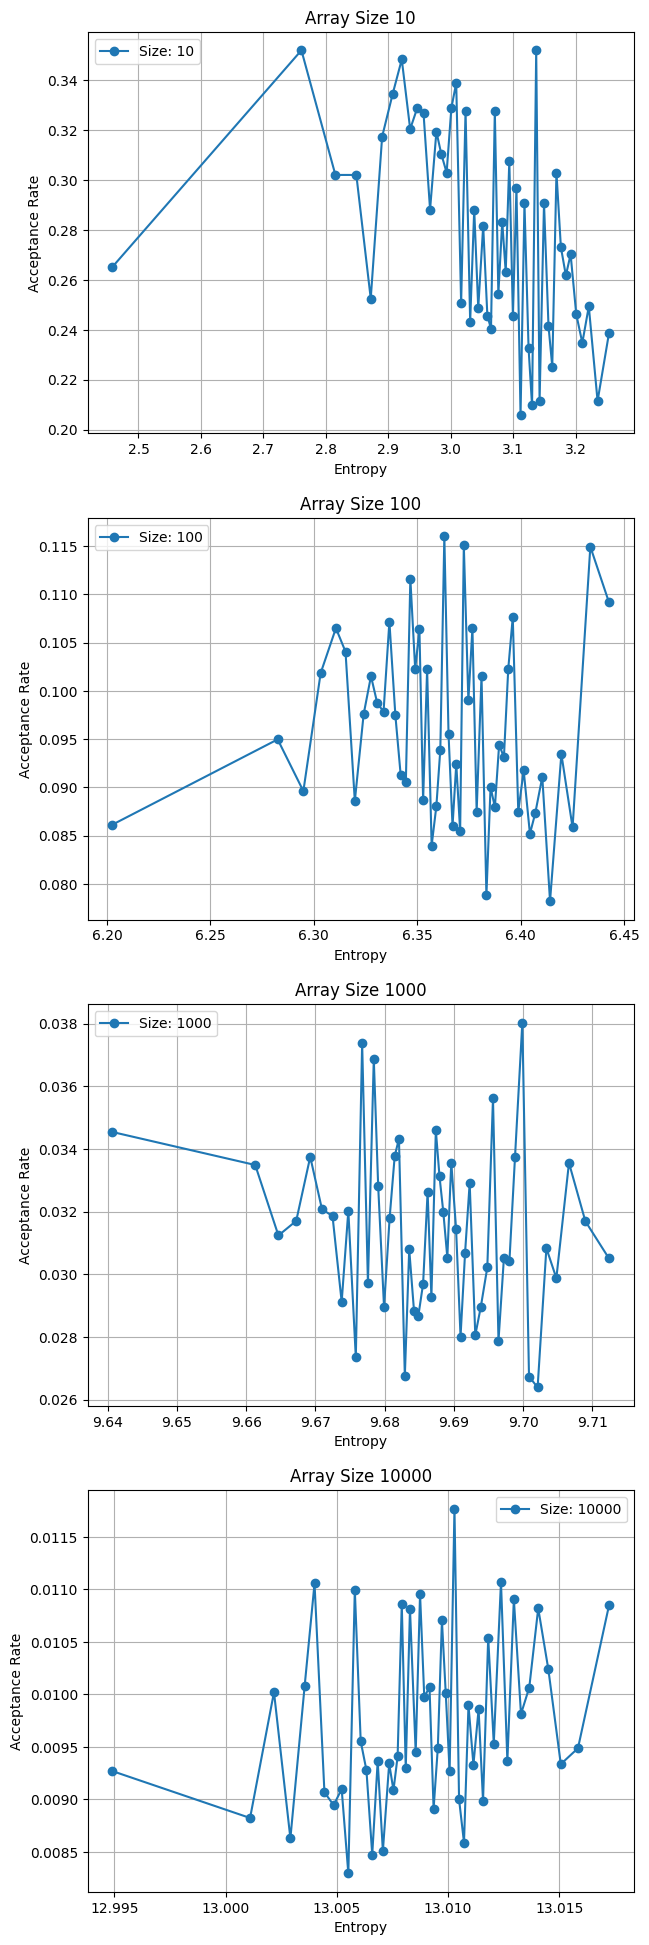

In [138]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=len(acceptance_rates_entropy), ncols=1, figsize=(7, 20))
fig.tight_layout(pad=4.0)

# Iterate over the sizes and their corresponding entropy dictionaries
for ax, (size, entropy_dict) in zip(axes, acceptance_rates_entropy.items()):
    entropy_values = list(entropy_dict.keys())
    rates = list(entropy_dict.values())
    
    ax.plot(entropy_values, rates, marker='o', label=f'Size: {size}')
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Acceptance Rate')
    ax.set_title(f'Array Size {size}')
    ax.legend()
    ax.grid(True)

plt.show()

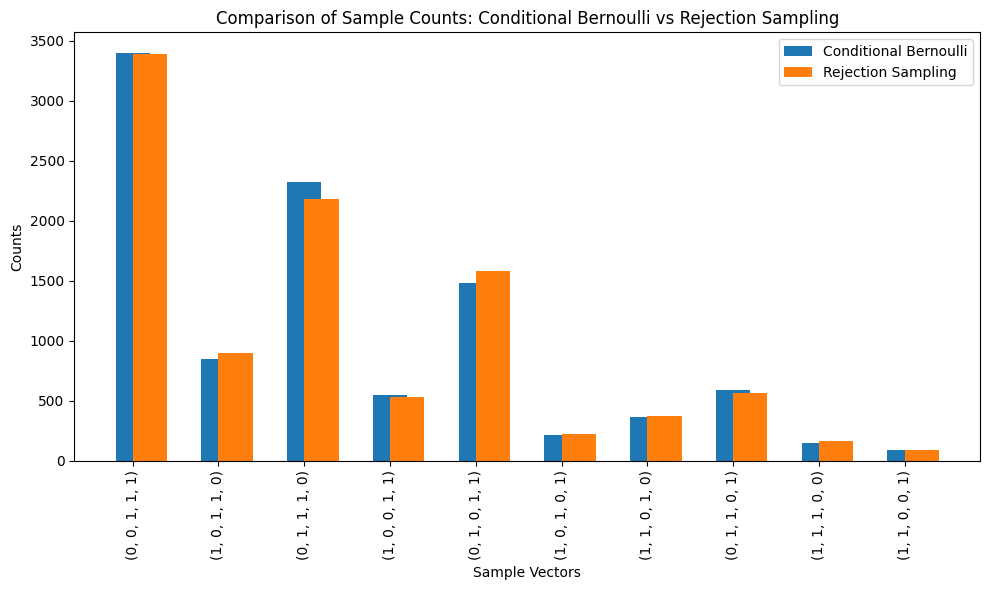

In [159]:
from collections import Counter

def sample_conditional_bernoulli(p, I):
    """
    Samples from independent Bernoulli(p_i) variables conditioned on sum == I
    using the exact algorithm from Appendix A of Heng, Jacob, and Ju (2020).

    Parameters:
    - p: array-like of length N with values in (0,1)
    - I: integer, target sum of the Bernoulli vector

    Returns:
    - x: binary numpy array of length N such that sum(x) == I
    """
    p = np.asarray(p)
    N = len(p)

    # Initialize q table: q[i][n] = P(sum_{m=n}^N X_m = i)
    q = np.zeros((I + 2, N + 2))  # extra row and column for indexing convenience
    q[0, N + 1] = 1.0  # q(0, N+1) = 1

    # Step 1: compute q(0, n) recursively
    for n in range(N, 0, -1):
        q[0, n] = (1 - p[n - 1]) * q[0, n + 1]

    # Step 2: recursive computation for i = 1 to I
    for i in range(1, I + 1):
        q[i, N + 1] = 0.0  # initialize base case
        for n in range(N, 0, -1):
            q[i, n] = (1 - p[n - 1]) * q[i, n + 1]
            if i - 1 >= 0:
                q[i, n] += p[n - 1] * q[i - 1, n + 1]

    # Step 3: sample x sequentially
    x = np.zeros(N, dtype=int)
    remaining = I
    for n in range(1, N + 1):
        if remaining == 0:
            break  # fill the rest with zeros
        denom = q[remaining, n]
        if denom == 0:
            continue  # numerical safeguard
        num = p[n - 1] * q[remaining - 1, n + 1]
        r = num / denom
        x_n = np.random.rand() < r
        x[n - 1] = x_n
        if x_n:
            remaining -= 1

    return x



# Fixed p array of size 5
p_fixed = np.array([0.2, 0.4, 0.6, 0.8, 0.5])
k_fixed = 3

# Generate 10000 samples using conditional Bernoulli
conditional_samples = [tuple(sample_conditional_bernoulli(p_fixed, k_fixed)) for _ in range(10000)]
conditional_counts = Counter(conditional_samples)

# Generate 10000 samples using rejection sampling
rejection_samples, _ = rejection_sampler(p_fixed, k_fixed, n_samples=10000)
rejection_samples = [tuple(sample) for sample in rejection_samples]
rejection_counts = Counter(rejection_samples)



# Extract unique samples and their counts for both methods
conditional_x = list(conditional_counts.keys())
conditional_y = list(conditional_counts.values())

rejection_x = list(rejection_counts.keys())
# Sort the samples in the same order
rejection_x = [[int(val) for val in sample] for sample in rejection_x]
rejection_x_sorted = [list(sample) for sample in conditional_x if list(sample) in rejection_x]
rejection_x = rejection_x_sorted
rejection_y = [rejection_counts[tuple(sample)] for sample in conditional_x]


# Plot the counts for both methods
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Conditional Bernoulli Sampling counts
ax.bar(range(len(conditional_x)), conditional_y, width=0.4, label='Conditional Bernoulli', align='center')

# Plot Rejection Sampling counts
ax.bar(range(len(rejection_x)), rejection_y, width=0.4, label='Rejection Sampling', align='edge')

# Set x-axis labels and ticks
ax.set_xticks(range(len(conditional_x)))
ax.set_xticklabels([str(sample) for sample in conditional_x], rotation=90)

# Add labels, title, and legend
ax.set_xlabel('Sample Vectors')
ax.set_ylabel('Counts')
ax.set_title('Comparison of Sample Counts: Conditional Bernoulli vs Rejection Sampling')
ax.legend()

plt.tight_layout()
plt.show()


In [153]:
conditional_x

[(0, 1, 1, 1, 0),
 (0, 1, 1, 0, 1),
 (1, 0, 0, 1, 1),
 (0, 0, 1, 1, 1),
 (1, 1, 1, 0, 0),
 (1, 0, 1, 1, 0),
 (0, 1, 0, 1, 1),
 (1, 1, 0, 1, 0),
 (1, 0, 1, 0, 1),
 (1, 1, 0, 0, 1)]

In [ ]:
rejection_x = [[int(val) for val in sample] for sample in rejection_x]
rejection_x
rejection_x_sorted = [list(sample) for sample in conditional_x if list(sample) in rejection_x]
rejection_x = rejection_x_sorted

[[1, 1, 0, 1, 0],
 [0, 0, 1, 1, 1],
 [0, 1, 1, 1, 0],
 [1, 0, 1, 1, 0],
 [1, 0, 1, 0, 1],
 [1, 1, 1, 0, 0],
 [1, 0, 0, 1, 1],
 [1, 1, 0, 0, 1],
 [0, 1, 1, 0, 1],
 [0, 1, 0, 1, 1]]